# Residual Networks

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import urllib.request
import zipfile

In [2]:
train_dataset = h5py.File('train_signs.h5', "r")
x_train = np.array(train_dataset["train_set_x"][:]) 
y_train = np.array(train_dataset["train_set_y"][:])

test_dataset = h5py.File('test_signs.h5', "r")
x_test = np.array(test_dataset["test_set_x"][:]) 
y_test = np.array(test_dataset["test_set_y"][:])

In [3]:
X_train = np.array(x_train, dtype='float32')
Y_train = np.array(np.reshape(np.eye(6)[y_train],(-1,6)), dtype='float32')

X_test = np.array(x_test, dtype='float32')
Y_test = np.array(np.reshape(np.eye(6)[y_test],(-1,6)), dtype='float32')

It's a 2


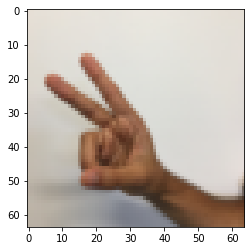

In [4]:
index = 6
plt.imshow(np.array(X_train[index,:,:,:], dtype='int32'))
print("It's a {}".format(y_train[index]))

In [5]:
class Identity_Block(tf.keras.layers.Layer):
    
    def __init__(self, kernel_size, filters):
        super().__init__()
        self.f1 = tf.keras.layers.Conv2D(filters=filters[0], 
                                         kernel_size=(1,1), 
                                         strides=(1,1), 
                                         padding='valid', 
                                         activation='linear', 
                                         kernel_initializer='glorot_uniform', 
                                         bias_initializer='zeros')
        self.f2 = tf.keras.layers.BatchNormalization(axis=3)
        self.f3 = tf.keras.layers.Activation(activation='relu')
        self.f4 = tf.keras.layers.Conv2D(filters=filters[1], 
                                         kernel_size=kernel_size, 
                                         strides=(1,1), 
                                         padding='same', 
                                         activation='linear', 
                                         kernel_initializer='glorot_uniform', 
                                         bias_initializer='zeros')
        self.f5 = tf.keras.layers.BatchNormalization(axis=3)
        self.f6 = tf.keras.layers.Activation(activation='relu')
        self.f7 = tf.keras.layers.Conv2D(filters=filters[2], 
                                         kernel_size=(1,1), 
                                         strides=(1,1), 
                                         padding='valid', 
                                         activation='linear', 
                                         kernel_initializer='glorot_uniform', 
                                         bias_initializer='zeros')
        self.f8 = tf.keras.layers.BatchNormalization(axis=3)
        self.f9 = tf.keras.layers.Add()
        self.f10 = tf.keras.layers.Activation(activation='relu')
        
    def call(self, inputs):
        a1 = self.f1(inputs)
        a2 = self.f2(a1)
        a3 = self.f3(a2)
        a4 = self.f4(a3)
        a5 = self.f5(a4)
        a6 = self.f6(a5)
        a7 = self.f7(a6)
        a8 = self.f8(a7)
        a9 = self.f9([a8,inputs])
        y = self.f10(a9)
        return y

In [6]:
class Convolutional_Block(tf.keras.layers.Layer):
    
    def __init__(self, kernel_size, filters, strides):
        super().__init__()
        self.f1 = tf.keras.layers.Conv2D(filters=filters[0], 
                                         kernel_size=(1,1), 
                                         strides=strides, 
                                         padding='valid', 
                                         activation='linear', 
                                         kernel_initializer='glorot_uniform', 
                                         bias_initializer='zeros')
        self.f2 = tf.keras.layers.BatchNormalization(axis=3)
        self.f3 = tf.keras.layers.Activation(activation='relu')
        self.f4 = tf.keras.layers.Conv2D(filters=filters[1], 
                                         kernel_size=kernel_size, 
                                         strides=(1,1), 
                                         padding='same', 
                                         activation='linear', 
                                         kernel_initializer='glorot_uniform', 
                                         bias_initializer='zeros')
        self.f5 = tf.keras.layers.BatchNormalization(axis=3)
        self.f6 = tf.keras.layers.Activation(activation='relu')
        self.f7 = tf.keras.layers.Conv2D(filters=filters[2], 
                                         kernel_size=(1,1), 
                                         strides=(1,1), 
                                         padding='valid', 
                                         activation='linear', 
                                         kernel_initializer='glorot_uniform', 
                                         bias_initializer='zeros')
        self.f8 = tf.keras.layers.BatchNormalization(axis=3)
        self.f9 = tf.keras.layers.Conv2D(filters=filters[2], 
                                         kernel_size=(1,1), 
                                         strides=strides, 
                                         padding='valid', 
                                         activation='linear', 
                                         kernel_initializer='glorot_uniform', 
                                         bias_initializer='zeros')
        self.f10 = tf.keras.layers.BatchNormalization(axis=3)
        self.f11 = tf.keras.layers.Add()
        self.f12 = tf.keras.layers.Activation(activation='relu')
    
    def call(self, inputs):
        a1 = self.f1(inputs)
        a2 = self.f2(a1)
        a3 = self.f3(a2)
        a4 = self.f4(a3)
        a5 = self.f5(a4)
        a6 = self.f6(a5)
        a7 = self.f7(a6)
        a8 = self.f8(a7)
        a9 = self.f9(inputs)
        a10 = self.f10(a9)
        a11 = self.f11([a8,a10])
        y = self.f12(a11)
        return y

In [7]:
class ResNet50(tf.keras.Model):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.f1 = tf.keras.layers.Lambda(function=lambda x: x/255.)
        self.f2 = tf.keras.layers.ZeroPadding2D(padding=(3,3))
        self.f3 = tf.keras.layers.Conv2D(filters=64, 
                                    kernel_size=(7,7), 
                                    strides=(2,2), 
                                    padding='valid', 
                                    activation='linear', 
                                    kernel_initializer='glorot_uniform', 
                                    bias_initializer='zeros')
        self.f4 = tf.keras.layers.BatchNormalization(axis=3)
        self.f5 = tf.keras.layers.Activation(activation='relu')
        self.f6 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), 
                                          strides=(2,2), 
                                          padding='valid')
        self.f7 = Convolutional_Block(kernel_size=(3,3), 
                                 filters=[64, 64, 256], 
                                 strides=(1,1))
        self.f8 = Identity_Block(kernel_size=(3,3), 
                            filters=[64, 64, 256])
        self.f9 = Identity_Block(kernel_size=(3,3), 
                            filters=[64, 64, 256])
        self.f10 = Convolutional_Block(kernel_size=(3,3), 
                                  filters=[128, 128, 512],
                                  strides=(2,2))
        self.f11 = Identity_Block(kernel_size=(3,3), 
                             filters=[128, 128, 512])
        self.f12 = Identity_Block(kernel_size=(3,3), 
                             filters=[128, 128, 512])
        self.f13 = Identity_Block(kernel_size=(3,3), 
                             filters=[128, 128, 512])
        self.f14 = Convolutional_Block(kernel_size=(3,3), 
                                  filters=[256, 256, 1024],
                                  strides=(2,2))
        self.f15 = Identity_Block(kernel_size=(3,3), 
                             filters=[256, 256, 1024])
        self.f16 = Identity_Block(kernel_size=(3,3), 
                             filters=[256, 256, 1024])
        self.f17 = Identity_Block(kernel_size=(3,3), 
                             filters=[256, 256, 1024])
        self.f18 = Identity_Block(kernel_size=(3,3), 
                             filters=[256, 256, 1024])
        self.f19 = Identity_Block(kernel_size=(3,3), 
                             filters=[256, 256, 1024])
        self.f20 = Convolutional_Block(kernel_size=(3,3), 
                                  filters=[512, 512, 2048],
                                  strides=(2,2))
        self.f21 = Identity_Block(kernel_size=(3,3), 
                             filters=[512, 512, 2048])
        self.f22 = Identity_Block(kernel_size=(3,3), 
                             filters=[512, 512, 2048])
        self.f23 = tf.keras.layers.AveragePooling2D(pool_size=(2,2), 
                                               strides=None, 
                                               padding='valid')
        self.f24 = tf.keras.layers.Flatten()
        self.f25 = tf.keras.layers.Dense(units=self.output_dim, 
                                    activation='softmax', 
                                    kernel_initializer='glorot_uniform', 
                                    bias_initializer='zeros')
        
    def call(self, inputs): 
        a1 = self.f1(inputs)
        a2 = self.f2(a1)
        a3 = self.f3(a2)
        a4 = self.f4(a3)
        a5 = self.f5(a4)
        a6 = self.f6(a5)
        a7 = self.f7(a6)
        a8 = self.f8(a7)
        a9 = self.f9(a8)
        a10 = self.f10(a9)
        a11 = self.f11(a10)
        a12 = self.f12(a11)
        a13 = self.f13(a12)
        a14 = self.f14(a13)
        a15 = self.f15(a14)
        a16 = self.f16(a15)
        a17 = self.f17(a16)
        a18 = self.f18(a17)
        a19 = self.f19(a18)
        a20 = self.f20(a19)
        a21 = self.f21(a20)
        a22 = self.f22(a21)
        a23 = self.f23(a22)
        a24 = self.f24(a23)
        y = self.f25(a24)
        return y
    
    def fit(self, x, y, learning_rate=0.01, batch_size=64, epochs=100, beta_1=0.9, beta_2=0.999, epsilon=1e-07, verbose=True):
        loss = tf.keras.losses.CategoricalCrossentropy()
        metric = tf.keras.metrics.CategoricalAccuracy()
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
        self.compile(loss=loss, metrics=[metric], optimizer=optimizer)
        self.summary(input_dim=self.input_dim)
        super().fit(x=x, y=y, batch_size=batch_size, epochs=epochs, verbose=verbose)
        
    def summary(self, input_dim):
        x = tf.keras.Input(shape=input_dim)
        y = self(x)
        super().summary()

In [8]:
resnet50 = ResNet50(input_dim=X_train.shape[1:], 
                    output_dim=Y_train.shape[1])

resnet50.fit(x=X_train, y=Y_train, epochs=2, learning_rate=0.001, batch_size=32)

Model: "res_net50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
convolutional__block (Convol (None, 15, 15, 256)       76

In [9]:
resnet50.evaluate(X_train, Y_train)

1080/1080 [==============================] - 5s 5ms/sample - loss: 7.5725 - categorical_accuracy: 0.1667


[7.57253857365361, 0.16666667]

In [10]:
resnet50.evaluate(X_test, Y_test)

120/120 [==============================] - 0s 4ms/sample - loss: 7.5745 - categorical_accuracy: 0.1667


[7.574506187438965, 0.16666667]

-----

In [11]:
X_train_ = X_train/255.
Y_train_ = Y_train

X_test_ = X_test/255.
Y_test_ = Y_test

In [12]:
url = 'https://firebasestorage.googleapis.com/v0/b/z2tma61d2a74hya815w9x621uszb3a.appspot.com/o/ResNet50.h5.zip?alt=media&token=51524b8b-7f10-4c4e-993f-e9f30348a301'
local_zip = 'ResNet50.h5.zip'
urllib.request.urlretrieve(url, local_zip)
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [13]:
resnet50_ = tf.keras.models.load_model(filepath='ResNet50.h5')
resnet50_.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [14]:
resnet50_.evaluate(X_train_, Y_train_)

1080/1080 [==============================] - 5s 5ms/sample - loss: 0.3063 - accuracy: 0.9056


[0.3063314074719394, 0.90555555]

In [15]:
resnet50_.evaluate(X_test_, Y_test_)

120/120 [==============================] - 0s 3ms/sample - loss: 0.5302 - accuracy: 0.8667


[0.5301782925923665, 0.8666667]

It's a 2


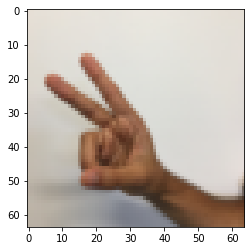

In [16]:
index = 6
plt.imshow(np.array(X_train[index,:,:,:], dtype='int32'))
print("It's a {}".format(np.argmax(resnet50_.predict(X_train[[index],:,:,:]/255.))))

It's a 3


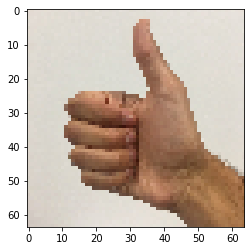

In [17]:
img = np.array(plt.imread("thumbs_up.jpg"))
img_ = np.array(Image.fromarray(img).resize((64,64)))
plt.imshow(img_)
img__ = np.expand_dims(img_, axis=0)
print("It's a {}".format(np.argmax(resnet50_.predict(img__/255.))))

It's a 4


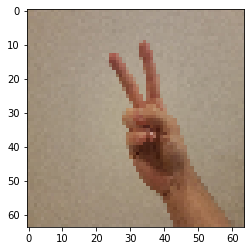

In [18]:
img = np.array(plt.imread("two_fingers.jpg"))
img_ = np.array(Image.fromarray(img).resize((64,64)))
plt.imshow(img_)
img__ = np.expand_dims(img_, axis=0)
print("It's a {}".format(np.argmax(resnet50_.predict(img__/255.))))

It's a 5


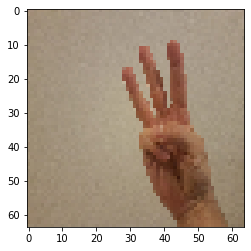

In [19]:
img = np.array(plt.imread("three_fingers.jpg"))
img_ = np.array(Image.fromarray(img).resize((64,64)))
plt.imshow(img_)
img__ = np.expand_dims(img_, axis=0)
print("It's a {}".format(np.argmax(resnet50_.predict(img__/255.))))